In [1]:
import os
from collections import Counter
import nltk
import gensim  #for topic modelling
from bs4 import BeautifulSoup #for extracting text 
import nltk # for text preprocessing
import re 
import pandas as pd
import numpy as np
import sys
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from nltk.corpus import stopwords 
from nltk.stem.wordnet import WordNetLemmatizer
from wordcloud import WordCloud, STOPWORDS
import string
from sklearn.decomposition import NMF
import matplotlib 
import matplotlib.pyplot as plt
import pyLDAvis.gensim
pyLDAvis.enable_notebook()
%matplotlib inline
pd.options.mode.chained_assignment = None
pd.options.display.max_columns = 999
matplotlib.rcParams['figure.figsize'] = (20,10)

import warnings
warnings.filterwarnings('ignore')

### read data

In [2]:
path = './inaugural_speeches/'
files = [path + fname for fname in os.listdir(path)]
files[0]

'./inaugural_speeches/37_roosevelt_franklin_1933.txt'

In [3]:
data = []
for fname in files:
    with open(fname, 'r') as f:
        lines = ' '.join(f.readlines())
        data.append(lines)

In [4]:
stoplist = set([u'state', u'country', u'nation', u'people', u'constitution',u'duty', u'government', u'citizen', u'law', u'right', u'union',u'power', u'year', u'world', u'interest', u'purpose', u'justice',u'principle', u'it', u'time', u'question', u'executive', u'war',u'peace', u'life', u'institution', u'condition', u'effort', u'land',u'faith', u'place', u'office', u'today', u'thing', u'opinion',u'home', u'action', u'god', u'cause', u'century', u'strength', u'danger', u'revenue',u'subject',u'republic', 'ha', 'man', 'men', 'day', 'hope', 'u'])
#stoplist = set([u'state', u'country', u'nation', u'people', u'constitution',u'duty', u'government', u'citizen'])

###  remove stopwords, punctuation, pos tag

In [5]:
stop = set(stopwords.words('english'))
stop.update(stoplist)
exclude = set(string.punctuation)
lemma = WordNetLemmatizer()
def clean(doc):
    punc_free = ''.join(ch for ch in doc if ch not in exclude)
    normalized = " ".join(lemma.lemmatize(word) for word in punc_free.split())
    doc_filter = " ".join([word for word, pos in nltk.pos_tag(normalized.lower().split()) if pos=='NN' ])
    stop_free = ' '.join([i for i in doc_filter.split() if i not in stop])

    #doc_count = pd.Series(stop_free).value_counts()
    #doc_count = set(doc_count[doc_count==1].index.values)
    #new_words = ' '.join([w for w in stop_free if w not in doc_count])
    
    return stop_free

In [6]:
doc_clean = [clean(doc).split() for doc in data]

### pos distribution

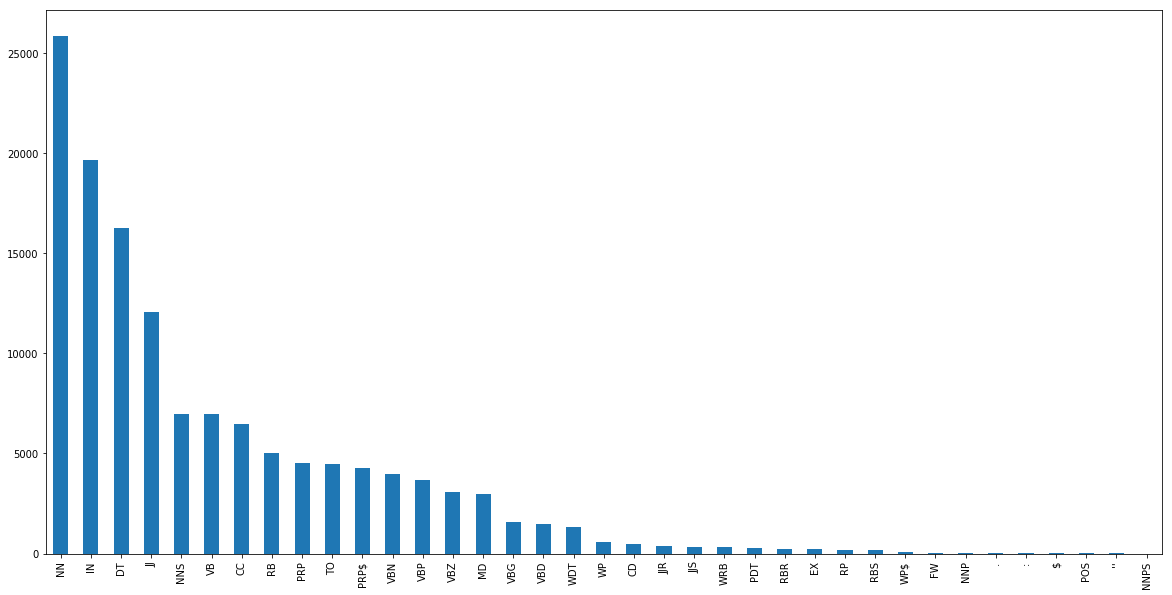

In [7]:
pos = [pos for doc in data for word, pos in nltk.pos_tag(doc.lower().split())]
pos = pd.Series(pos)
pos.value_counts().head(50).plot.bar()

### word distribution

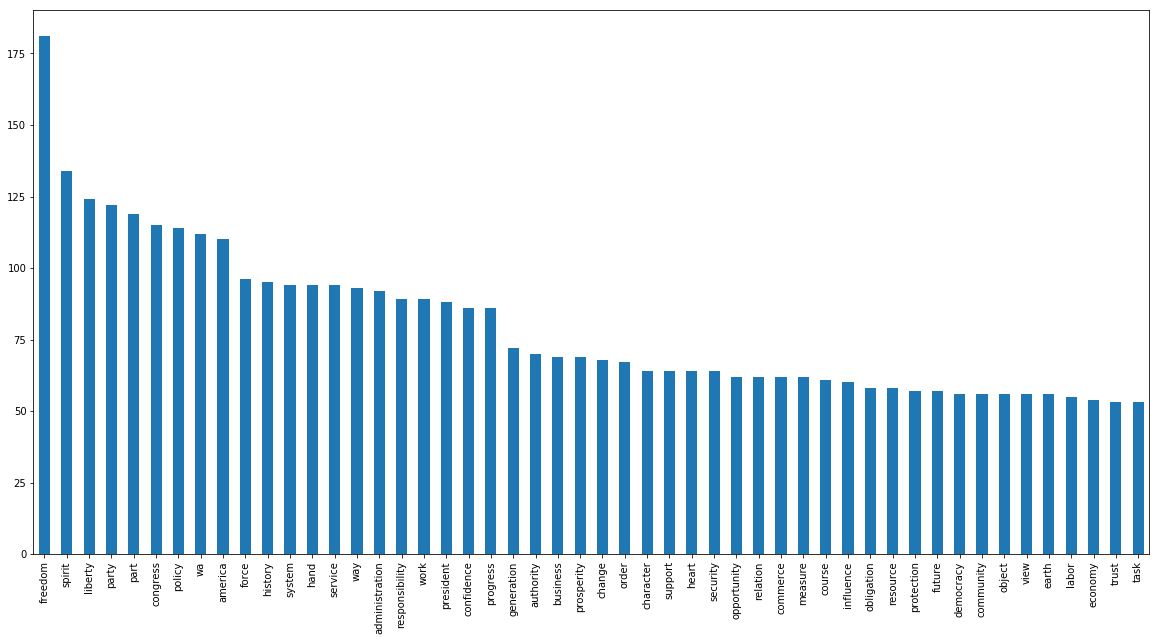

In [8]:
all_tokens = [x for y in doc_clean for x in y]
all_tokens = pd.Series(all_tokens)
all_tokens.value_counts().head(50).plot.bar()

In [9]:
all_tokens.value_counts().head(50).index.values

array(['freedom', 'spirit', 'liberty', 'party', 'part', 'congress',
       'policy', 'wa', 'america', 'force', 'history', 'system', 'hand',
       'service', 'way', 'administration', 'responsibility', 'work',
       'president', 'confidence', 'progress', 'generation', 'authority',
       'business', 'prosperity', 'change', 'order', 'character', 'support',
       'heart', 'security', 'opportunity', 'relation', 'commerce',
       'measure', 'course', 'influence', 'obligation', 'resource',
       'protection', 'future', 'democracy', 'community', 'object', 'view',
       'earth', 'labor', 'economy', 'trust', 'task'], dtype=object)

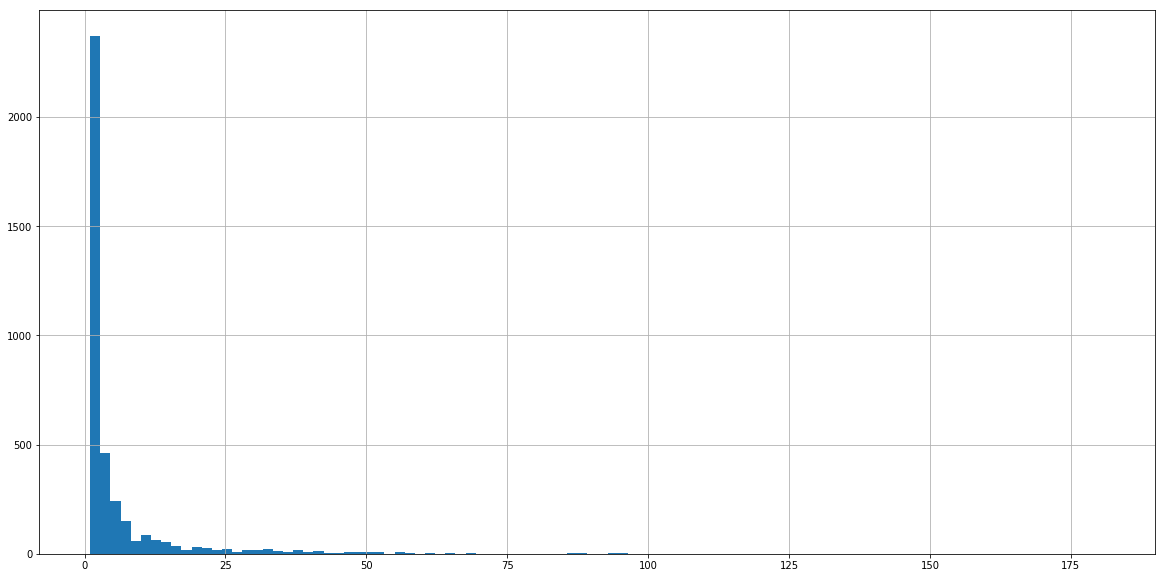

In [10]:
all_tokens.value_counts().hist(bins=100)

### plot theme of some transcripts

(-0.5, 399.5, 199.5, -0.5)

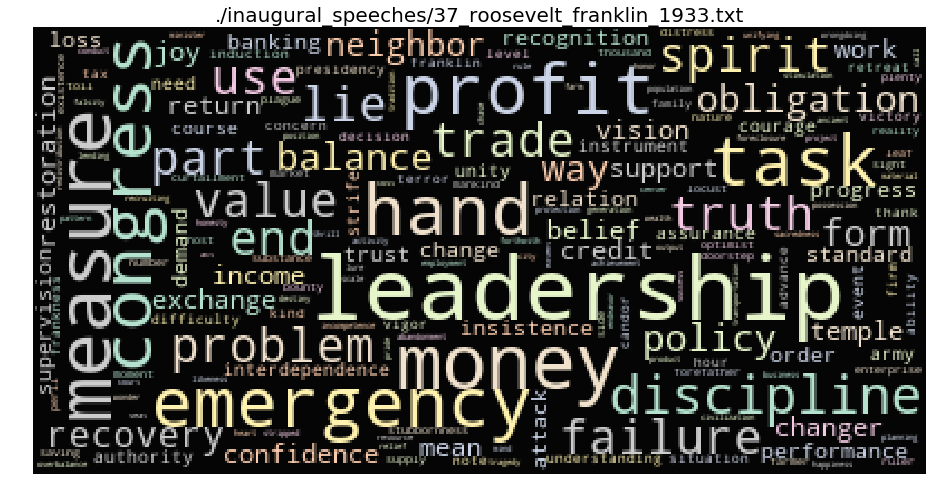

In [11]:
plt.figure(figsize=(16,13))
wc = WordCloud(background_color="black", max_words=10000, 
               stopwords=STOPWORDS, max_font_size= 40)
wc.generate(' '.join(doc_clean[0]))
plt.title(files[0], fontsize=20)
# plt.imshow(wc.recolor( colormap= 'Pastel1_r' , random_state=17), alpha=0.98)
plt.imshow(wc.recolor( colormap= 'Pastel2' , random_state=17), alpha=0.98)
plt.axis('off')

(-0.5, 399.5, 199.5, -0.5)

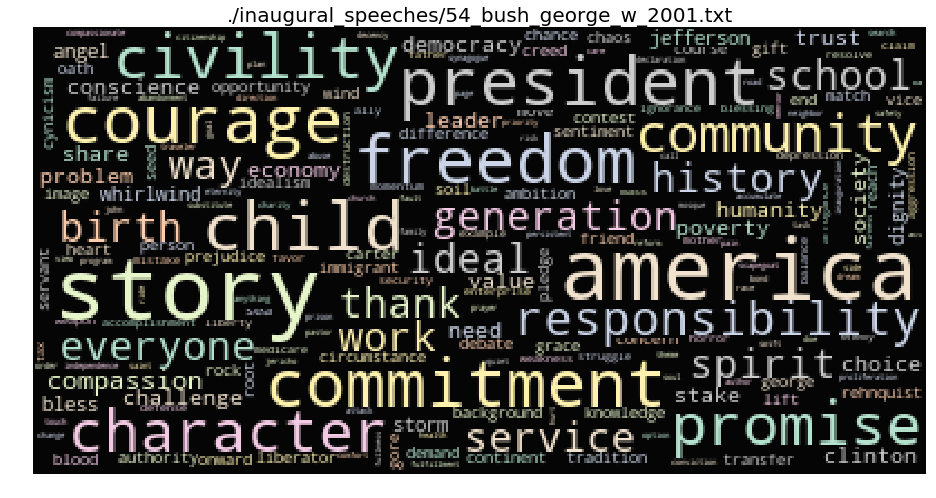

In [12]:
plt.figure(figsize=(16,13))
wc = WordCloud(background_color="black", max_words=10000, 
               stopwords=STOPWORDS, max_font_size= 40)
wc.generate(' '.join(doc_clean[1]))
plt.title(files[1], fontsize=20)
# plt.imshow(wc.recolor( colormap= 'Pastel1_r' , random_state=17), alpha=0.98)
plt.imshow(wc.recolor( colormap= 'Pastel2' , random_state=17), alpha=0.98)
plt.axis('off')

(-0.5, 399.5, 199.5, -0.5)

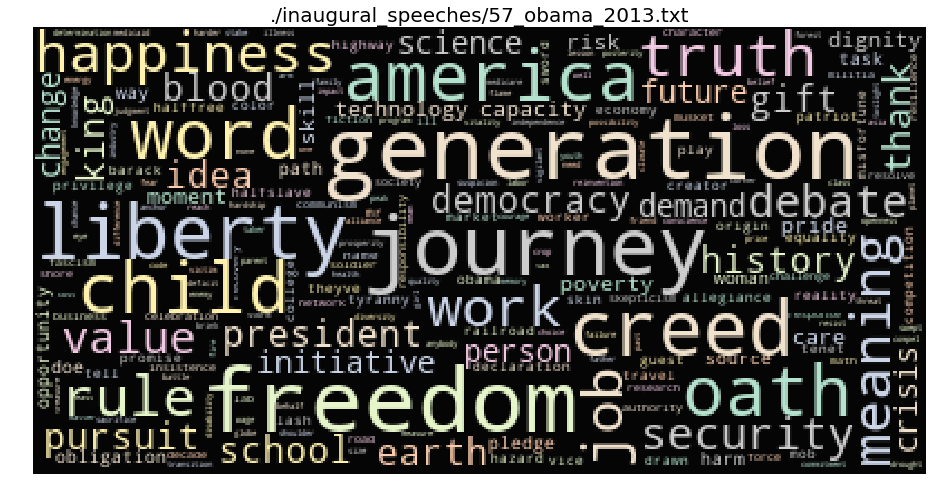

In [13]:
plt.figure(figsize=(16,13))
wc = WordCloud(background_color="black", max_words=10000, 
               stopwords=STOPWORDS, max_font_size= 40)
wc.generate(' '.join(doc_clean[23]))
plt.title(files[23], fontsize=20)
# plt.imshow(wc.recolor( colormap= 'Pastel1_r' , random_state=17), alpha=0.98)
plt.imshow(wc.recolor( colormap= 'Pastel2' , random_state=17), alpha=0.98)
plt.axis('off')

In [14]:
word_counts = pd.Series(np.concatenate(doc_clean)).value_counts()
singular_words = set(word_counts[pd.Series(np.concatenate(doc_clean)).value_counts() <= 2].index)

In [15]:
len(singular_words)

2370

In [16]:
doc_stemmed = [[word for word in title if word not in singular_words] for title in doc_clean]

In [17]:
non_empty_indices = [i for i in range(len(doc_stemmed)) if len(doc_stemmed[i]) > 0]
doc_stemmed = np.asarray(doc_stemmed)[non_empty_indices]

In [18]:
dictionary = gensim.corpora.Dictionary(doc_stemmed)

In [19]:
corpus = [dictionary.doc2bow(text) for text in doc_stemmed]


In [20]:
model =  gensim.models.ldamodel.LdaModel
ldamodel = model(corpus, num_topics=20, id2word = dictionary, passes=200)

In [21]:
pyLDAvis.gensim.prepare(ldamodel, corpus, dictionary)

TypeError: Object of type 'complex' is not JSON serializable

PreparedData(topic_coordinates=            Freq  cluster  topics                      x  \
topic                                                      
0      16.408974        1       1    (0.108372254329+0j)   
8      15.302078        1       2    (0.214542588986+0j)   
1       9.262023        1       3  (-0.0968624788005+0j)   
6       9.060888        1       4   (-0.195968420341+0j)   
10      7.883421        1       5   (-0.120090537188+0j)   
15      7.781399        1       6   (0.0677953487183+0j)   
7       7.717447        1       7  (-0.0825382505461+0j)   
3       7.376680        1       8   (-0.138717337415+0j)   
19      7.275166        1       9  (-0.0574687907329+0j)   
14      6.607675        1      10   (0.0501581518362+0j)   
2       2.156451        1      11  (0.00162558190667+0j)   
11      1.289141        1      12    (0.143865734627+0j)   
17      0.954165        1      13  (-0.0823451051683+0j)   
4       0.839379        1      14  (-0.0143413430718+0j)   
18      0

In [22]:
doc = [clean(doc) for doc in data]
wordvector = TfidfVectorizer(analyzer='word', stop_words='english', max_df=0.95, min_df=2)
wordvector_fit = wordvector.fit_transform(doc)
feature = wordvector.get_feature_names()

In [23]:
nmf = NMF(n_components=20, random_state=1, alpha=.1, l1_ratio=.5, init='nndsvd').fit(wordvector_fit.todense())

In [24]:
np.sum(np.square(wordvector_fit.todense()[23] - nmf.components_), axis=1)

matrix([[ 1.41462443],
        [ 0.70978231],
        [ 1.1907466 ],
        [ 1.17169242],
        [ 1.16347075],
        [ 1.08984423],
        [ 1.        ],
        [ 1.31189839],
        [ 1.11179071],
        [ 1.10042671],
        [ 1.18982771],
        [ 1.12896029],
        [ 1.16719187],
        [ 1.10276863],
        [ 1.1048314 ],
        [ 1.05935511],
        [ 1.        ],
        [ 1.12105873],
        [ 1.10967009],
        [ 1.15547048]])

In [25]:
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic %d:" % (topic_idx))
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))
display_topics(nmf, feature, 10)        

Topic 0:
party congress policy administration wa spirit object authority service confidence
Topic 1:
freedom america generation history democracy child work earth friend president
Topic 2:
business tariff congress amendment legislation employee race trade south statute
Topic 3:
thought counsel influence process consent forth consciousness task opportunity spirit
Topic 4:
responsibility role let era america retreat policy challenge promise structure
Topic 5:
democracy spirit america stock disruption body freedom midst person form
Topic 6:
zeal exercise evidence evil exaction examination example excellence exception exchange
Topic 7:
entertain injunction proper thereof oath ceremony punishment george magistrate execution
Topic 8:
preservation proportion importance observation event exercise intention loss liberty rest
Topic 9:
dream spirit mercy mistake ceremony respect armament weapon inauguration weakness
Topic 10:
offense insurgent address drawn wa conflict believer bread pray expirat

In [26]:
N = 20
clf = KMeans(n_clusters=N,
            max_iter=100,
            init='k-means++',
            n_init=1)
labels = clf.fit_predict(wordvector_fit)

In [27]:
wordvector_fit_2d = wordvector_fit.todense()
pca = PCA(n_components=2).fit(wordvector_fit_2d)
datapoint = pca.transform(wordvector_fit_2d)

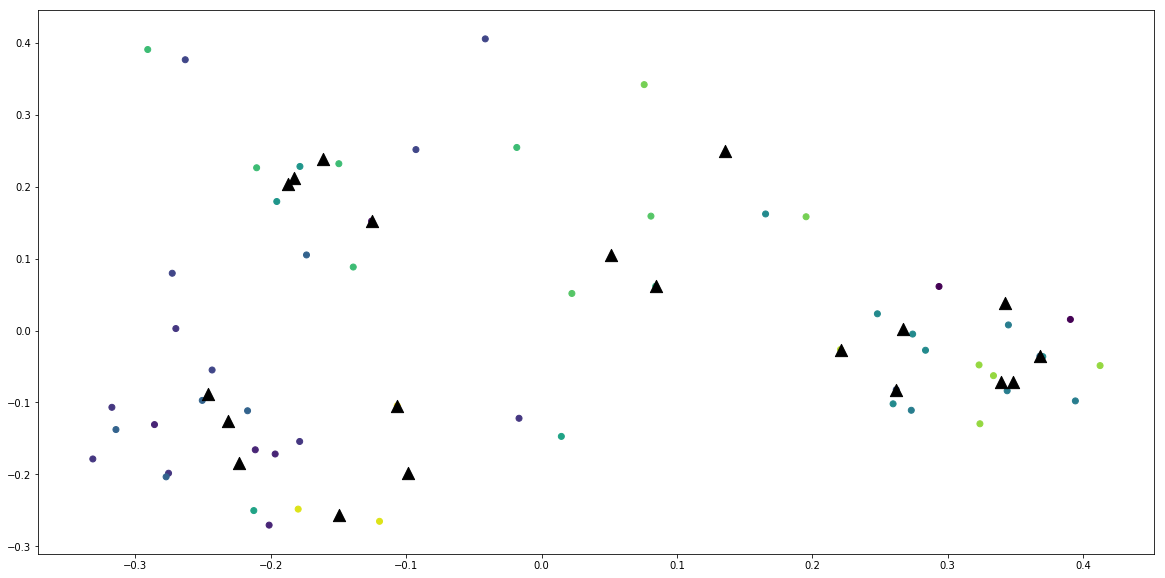

In [28]:

plt.scatter(datapoint[:, 0], datapoint[:, 1], c=labels)

centroids = clf.cluster_centers_
centroidpoint = pca.transform(centroids)
plt.scatter(centroidpoint[:, 0], centroidpoint[:, 1], marker='^', s=150, c='#000000')
plt.show()

In [29]:
ldamodel[corpus[0]]

[(14, 0.99704045)]

In [30]:
ldamodel.print_topic(11)

'0.018*"progress" + 0.015*"democracy" + 0.015*"way" + 0.012*"road" + 0.012*"disaster" + 0.012*"problem" + 0.009*"woman" + 0.009*"instrument" + 0.009*"prosperity" + 0.009*"despair"'

In [31]:
hdpmodel = gensim.models.HdpModel(corpus, id2word=dictionary)

In [32]:
pyLDAvis.gensim.prepare(hdpmodel, corpus, dictionary)

PreparedData(topic_coordinates=               Freq  cluster  topics         x         y
topic                                                   
0      2.115904e+01        1       1 -0.080919  0.001631
2      1.036286e+01        1       2 -0.070483  0.022661
1      7.810494e+00        1       3 -0.069591  0.001679
3      6.987715e+00        1       4 -0.077954  0.010492
5      6.119271e+00        1       5 -0.062795 -0.009884
4      5.736440e+00        1       6 -0.064131 -0.009340
6      4.867817e+00        1       7 -0.052181 -0.008102
7      3.664831e+00        1       8 -0.041030 -0.000256
8      3.330195e+00        1       9 -0.030611 -0.018185
9      2.973810e+00        1      10 -0.039488  0.023161
10     2.478026e+00        1      11 -0.043799  0.013510
13     2.285142e+00        1      12 -0.026000 -0.014443
12     1.840998e+00        1      13 -0.022582 -0.004909
14     1.740154e+00        1      14 -0.027373 -0.020652
19     1.695657e+00        1      15 -0.031065  0.016957
16     1.681590e+00        1      16 -0.029727  0.006253
17     1.541606e+00        1      17 -0.033677  0.021577
15     1.531505e+00        1      18 -0.029561  0.013841
11     1.473846e+00        1      19 -0.012999  0.004681
20     1.122466e+00        1      20 -0.014197  0.006725
18     1.048882e+00        1      21 -0.024457 -0.000792
23     9.795536e-01        1      22 -0.024409  0.002428
27     8.346321e-01        1      23 -0.020169 -0.008192
21     7.755250e-01        1      24 -0.006331 -0.014122
29     7.528433e-01        1      25 -0.008809  0.016530
30     7.408101e-01        1      26 -0.022154 -0.017127
28     6.339946e-01        1      27 -0.007083  0.001812
24     5.988642e-01        1      28 -0.019322 -0.004026
22     5.963316e-01        1      29 -0.004440  0.016579
31     5.900502e-01        1      30 -0.013815 -0.003030
...             ...      ...     ...       ...       ...
120    3.875124e-29        1     121  0.005339 -0.019600
121    1.937562e-29        1     122  0.007764 -0.024823
122    9.687810e-30        1     123  0.012074 -0.016504
123    4.843905e-30        1     124  0.006941 -0.012140
124    2.421953e-30        1     125  0.013715  0.014705
125    1.210976e-30        1     126  0.025667  0.026466
126    6.054881e-31        1     127 -0.000809  0.003480
127    3.027441e-31        1     128  0.022298  0.024873
128    1.513720e-31        1     129  0.014819  0.014518
129    7.568602e-32        1     130  0.013743  0.018514
130    3.784301e-32        1     131 -0.002145  0.024732
131    1.892151e-32        1     132  0.010509 -0.022412
132    9.460753e-33        1     133  0.013387  0.016102
133    4.730376e-33        1     134  0.004442 -0.011347
134    2.365188e-33        1     135  0.005937 -0.023976
135    1.182594e-33        1     136  0.007869 -0.033633
136    5.912971e-34        1     137  0.004445  0.017309
137    2.956485e-34        1     138  0.020268  0.010957
138    1.478243e-34        1     139  0.001450 -0.003681
139    7.391213e-35        1     140  0.017709  0.011991
140    3.695607e-35        1     141  0.019289  0.011275
141    1.847803e-35        1     142  0.007277 -0.020578
142    9.239017e-36        1     143  0.008234  0.007583
143    4.619508e-36        1     144  0.002164  0.021660
144    2.309754e-36        1     145  0.015559  0.001568
145    1.154877e-36        1     146  0.011373  0.000445
146    5.774385e-37        1     147  0.018135  0.003414
147    2.887193e-37        1     148  0.009340  0.000466
148    1.443596e-37        1     149  0.013588  0.001483
149    1.443596e-37        1     150  0.009556  0.021488

[150 rows x 5 columns], topic_info=      Category          Freq            Term      Total  loglift  logprob
term                                                                     
269    Default  7.800000e+01         freedom  78.000000  30.0000  30.0000
444    Default  5.500000e+01           party  55.000000  29.0000  29.0000
137    Default  4.900000e+01          policy  

In [33]:
hdpmodel[corpus[23]]

[(9, 0.99699678581337692)]

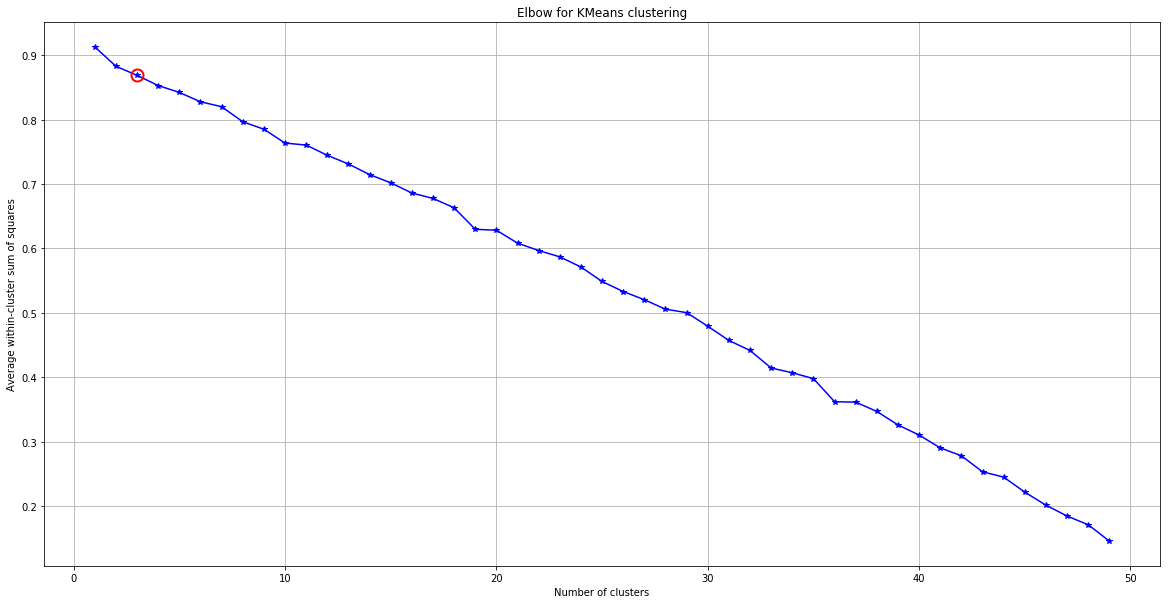

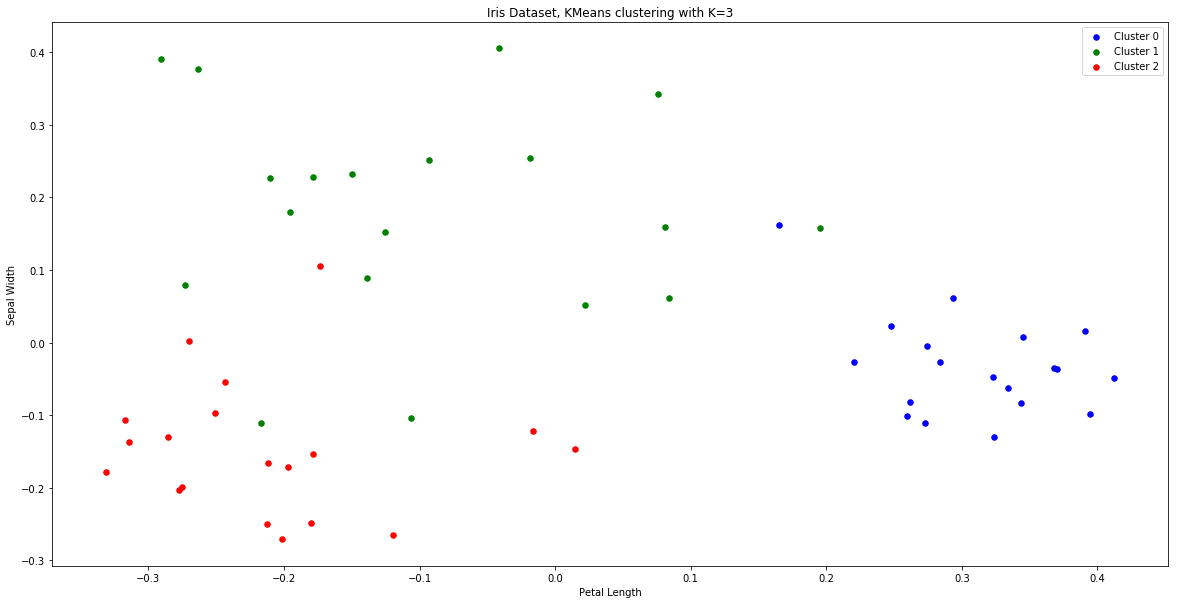

In [34]:
import numpy as np
from scipy.cluster.vq import kmeans,vq
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt

# load the iris dataset

X = wordvector_fit.todense()


##### cluster data into K=1..10 clusters #####
K = range(1,50)

# scipy.cluster.vq.kmeans
KM = [kmeans(X,k) for k in K]
centroids = [cent for (cent,var) in KM]   # cluster centroids
#avgWithinSS = [var for (cent,var) in KM] # mean within-cluster sum of squares

# alternative: scipy.cluster.vq.vq
#Z = [vq(X,cent) for cent in centroids]
#avgWithinSS = [sum(dist)/X.shape[0] for (cIdx,dist) in Z]

# alternative: scipy.spatial.distance.cdist
D_k = [cdist(X, cent, 'euclidean') for cent in centroids]
cIdx = [np.argmin(D,axis=1) for D in D_k]
dist = [np.min(D,axis=1) for D in D_k]
avgWithinSS = [sum(d)/X.shape[0] for d in dist]

##### plot ###
kIdx = 2

# elbow curve
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(K, avgWithinSS, 'b*-')
ax.plot(K[kIdx], avgWithinSS[kIdx], marker='o', markersize=12, 
    markeredgewidth=2, markeredgecolor='r', markerfacecolor='None')
plt.grid(True)
plt.xlabel('Number of clusters')
plt.ylabel('Average within-cluster sum of squares')
plt.title('Elbow for KMeans clustering')

# scatter plot
fig = plt.figure()
ax = fig.add_subplot(111)
#ax.scatter(X[:,2],X[:,1], s=30, c=cIdx[k])
clr = ['b','g','r','c','m','y','k']
for i in range(K[kIdx]):
    ind = (cIdx[kIdx]==i)
    ax.scatter(datapoint[ind,0],datapoint[ind,1], s=30, c=clr[i], label='Cluster %d'%i)
plt.xlabel('Petal Length')
plt.ylabel('Sepal Width')
plt.title('Iris Dataset, KMeans clustering with K=%d' % K[kIdx])
plt.legend()

plt.show()